### Churn Prediction - 12Gb Dataset

In [1]:
# Install and import libraries

sc.install_pypi_package("pandas==0.25.1") 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("scikit-learn")

import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1582050126019_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl (10.5 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.1.3-cp36-cp36m-manylinux1_x86_64.whl (13.1 MB)
  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (90 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached scikit_learn-0.22.1-cp36-cp36m-manylinux1_x86_64.whl (7.0 MB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)

In [2]:
# Make a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Project") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Loading the Data Set

df = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(df)

# Cleaning the Dataset
df = df.drop(*['artist','song','firstName', 'lastName', 'id_copy'])             # dropping some irrelevant columns
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])                   # droppping some potential NA values
df = df.filter(df.userId!='').orderBy(["userId", "ts"], ascending=[True, True]) # filtering out the invalid Ids
df = df.withColumn("userId", df["userId"].cast(IntegerType()))                  # case userId column to integer
 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Defining the Churn
# These are Customers landing on the Cancellation Confirmation page
cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
df = df.withColumn("churn", cancelation("page"))
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("churn", Fsum("churn").over(window))


##Some new columns were made in this step to make the data exploration easier, the Feature engineering step comes later

# Making the level_shift Column
# This column tells us how many times did the customer switched from paid to free service
window1 = Window.partitionBy().orderBy(["userId", "ts"])
df = df.withColumn("level_shift", (df.level!=F.lag(df.level).over(window1)) | (df.userId!=F.lag(df.userId).over(window1)))
df=df.fillna({'level_shift':0})
df= df.withColumn("level_shift", F.when(df["level_shift"]==False, 0).otherwise(1))


# Making the last_ts column
# This column will help us to select only records that happened in the last 2 weeks of customer activity
# The idea is that customer behavior should be different shortly before the churn happened

df= df.withColumn("ts", df.ts/1000)                        # trimming the last three zeros from the UNIX time (miliseconds)
df= df.withColumn("registration", df.registration/1000)

window2 = Window.partitionBy("userId")
df= df.withColumn("last_ts", F.max('ts').over(window2))
df=df.filter(df.last_ts - df.ts < 1300000) #2592000         # this is the approx number of seconds in a 2 week period


# Making the Columns: pages_per_session, diff_time
# pages_per_session is number of pages per session
# diff_time is a number of days since a specific page was visited

window3 = Window.partitionBy(["userId", "sessionId"])
df= df.withColumn("pages_per_session", F.max('ItemInSession').over(window3))
df = df.withColumn("ts_time",F.to_timestamp(df.ts))                    #  unix to datetime
df = df.withColumn("last_ts_time",F.to_timestamp(df.last_ts))          # unix to datetime

df = df.withColumn("diff_time",F.datediff(df.last_ts_time, df.ts_time))  # how many days ago was the page visited

df=df.orderBy(["userId", "ts"], ascending=[True, True])

df.createOrReplaceTempView('data');                                    # Create a Temp Table to be used foe SQL queries

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Data preview

df.limit(2).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        auth gender  ...        last_ts_time  diff_time
0  Logged In      M  ... 2018-10-18 20:33:05         15
1  Logged In      M  ... 2018-10-18 20:33:05         15

[2 rows x 21 columns]

In [6]:
# The column "page" seems to be most informative in the whole dataset
# It shows which pages of the service were visited by users, timestamp is also provided
# This column can be used to engineer useful features

df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|       5003|
|    Submit Downgrade|       2450|
|         Thumbs Down|      89370|
|                Home|     425269|
|           Downgrade|      73782|
|         Roll Advert|     125746|
|              Logout|     106746|
|       Save Settings|      10755|
|Cancellation Conf...|       5003|
|               About|      27272|
| Submit Registration|         98|
|            Settings|      54420|
|               Login|      63666|
|            Register|        208|
|     Add to Playlist|     221047|
|          Add Friend|     139143|
|            NextSong|    7709280|
|           Thumbs Up|     418797|
|                Help|      52636|
|             Upgrade|      15173|
+--------------------+-----------+
only showing top 20 rows

In [7]:
df.printSchema();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- churn: long (nullable = true)
 |-- level_shift: integer (nullable = false)
 |-- last_ts: double (nullable = true)
 |-- pages_per_session: long (nullable = true)
 |-- ts_time: timestamp (nullable = true)
 |-- last_ts_time: timestamp (nullable = true)
 |-- diff_time: integer (nullable = true)

In [8]:
# Investigation if there are differences between churned and non-churned users

# label             - 0 if non_churned, 1 if churned
# song_count        - avg number of songs played by churned/non_churned users
# error             - avg number of errors occuring 
# friends           - avg number of "friends" on thhe application
# playlist_count    - avg number of visits to the Playlist page
# thumbs_up         - avg number of clicking the 'thumbs up'
# thumbs_down       - avg number of clicking the 'thumbs down'
# downgrade         - avg number of visits to the downgrade page
# count_session_dist- avg number of sessions made
# count_diff_time   - avg number of days (in the last two weeks) in which the user used the app
# pages per session - avg numbers of pages (or any activity or changes) per session
# duration          - avg number of days since the user joined (division with 86400 as a proxy of seconds within a day)
# level_shift       - avg number of level changes (free, paid) per customer
# usage_time        - avg total time spent using the app


stats = spark.sql(" WITH prep as( \
SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
avg(distinct pages_per_session)                                     as pages_per_session, \
(max(ts) - min(registration))/86400                                 as duration, \
sum(level_shift)                                                    as level_shift, \
sum(length)                                                         as usage_time \
FROM data \
GROUP BY userId) \
SELECT label, \
count(label)             as cnt, \
avg(song_count)          as song_count, \
avg(error)               as error, \
avg(friends)             as friends, \
avg(playlist_count)      as playlist_count, \
avg(thumbs_up)           as thumbs_up, \
avg(thumbs_down)         as thumbs_down, \
avg(downgrade)           as downgrade, \
avg(count_session_dist)  as count_session_dist, \
avg(count_diff_time)     as count_diff_time, \
avg(pages_per_session)   as pages_per_session, \
avg(duration)            as duration, \
avg (level_shift)        as level_shift, \
avg(usage_time)          as usage_time \
FROM prep \
GROUP BY label")

# We can see that for most dimensions/features there are differences between churned and non-churned users
stats.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   label    cnt  song_count  ...   duration  level_shift     usage_time
0      0  17275  311.459103  ...  89.085637     2.723647   77847.838987
1      1   5003  465.485509  ...  63.718817     0.896462  115792.603501

[2 rows x 15 columns]

In [9]:
# Feature Enigneering

# Based on the previous analysis, all 14 investigated features will be included. 
# Here I am making a Temp Table which holds all the features.
# The temp table will be used as model input
# All data is aggregated per userId


features = spark.sql("SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
round(avg(distinct pages_per_session),0)                                     as pages_per_session, \
round((max(ts) - min(registration))/86400,0)                                as duration, \
round(sum(level_shift),0)                                                  as level_shift, \
round(sum(length),0)                                                         as usage_time \
FROM data \
GROUP BY userId");

features.createOrReplaceTempView('features');
features=features.na.drop() # clean potential NaNs


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Models

In [10]:

# Train Test Split
training, test = features.randomSplit([0.8, 0.2])


# Make VectorAssembler - this is a Pypark specific step
# All input features must be in one column before feeding into the model

assembler = VectorAssembler(inputCols=["userId","song_count","error","friends","playlist_count", \
                                       "thumbs_up","thumbs_down","downgrade", "count_session_dist",\
                                       "count_diff_time","pages_per_session", "duration","level_shift",\
                                       "usage_time"], \
                            outputCol="inputFeatures")



# Normalize Data
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")


# Spark supports most common classification methods (https://spark.apache.org/docs/latest/ml-classification-regression.html)
# I decided for the following three:

lr=LogisticRegression()
gbt = GBTClassifier()
rf= RandomForestClassifier()


# Building pipelines
pipeline1=Pipeline(stages=[assembler, scaler, lr])
pipeline2=Pipeline(stages=[assembler, scaler, gbt])
pipeline3=Pipeline(stages=[assembler, scaler, rf])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Logistic Regression

In [11]:
# metric chosen is f1 (we want to catch true positives (churn customers), but
# we do not want to waste money on false positives (investing in retaining non-churn customers, which are loyal anyway)
# Note that Recall might also be justified to use here (if the cost of false positives is low)


paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\
.build()


evaluator=MulticlassClassificationEvaluator(metricName="f1")
#evaluator=BinaryClassificationEvaluator( metricName="areaUnderROC")

# Crossvalidator (https://spark.apache.org/docs/2.1.3/api/python/_modules/pyspark/ml/tuning.html)

crossval= CrossValidator(estimator=pipeline1,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator , 
                         numFolds=3
                        )

cvModel1=crossval.fit(training) 
evaluator.evaluate(cvModel1.transform(test))

#cvModel1.subModels() 
#cvModel1.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.692604902830179

#### Gradient Boosted Tree Classifier

In [12]:


# Specify multiple parameters in the paramgrid, in case you have enough processing power 
paramgrid1 =ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline2,  
                         estimatorParamMaps=paramgrid1,
                         evaluator=evaluator, 
                         numFolds=3
                        )

cvModel2=crossval.fit(training) 
evaluator.evaluate(cvModel2.transform(test))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-12:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2577



0.8156833657006172

#### Random Forest

In [13]:

# Specify multiple parameters in the paramgrid, in case you have enough processing power
paramgrid2 =ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")
#evaluator=BinaryClassificationEvaluator( metricName="areaUnderROC")

crossval= CrossValidator(estimator=pipeline3,  
                         estimatorParamMaps=paramgrid2,
                         evaluator=evaluator, 
                         numFolds=3
                        )

cvModel3=crossval.fit(training) 
evaluator.evaluate(cvModel3.transform(test))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-13:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6095



0.8032541507889631

In [14]:
predictions=cvModel2.transform(test)
#predictions.limit(2).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Visualisations

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

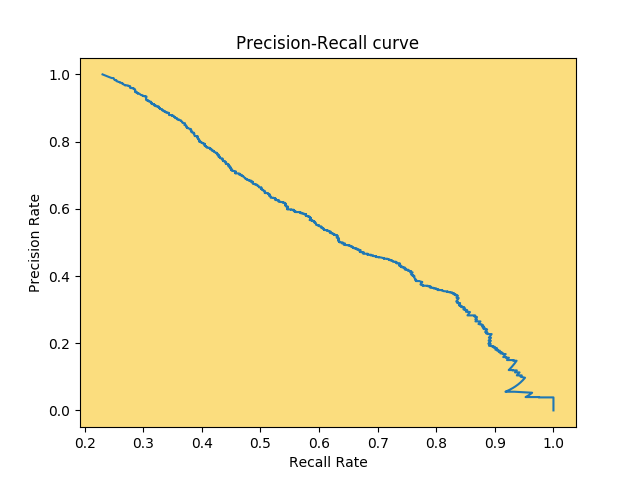

In [15]:
# Gradient Boosted Tree Classifier seems to be the winner model, let us plot its Precision-Recall Curve
 

def pr(ax, predictions, labels, title='Precision-Recall curve'):
    ''' outputs the roc curve on ax axes'''
    prediction_prob = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    pr, rc, _ = precision_recall_curve(labels, prediction_prob)
    ax.plot(pr, rc)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('Recall Rate')
    ax.set_ylabel('Precision Rate')
    ax.set_title(title)
   

plt.clf()

labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
pr(ax, predictions,labels)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

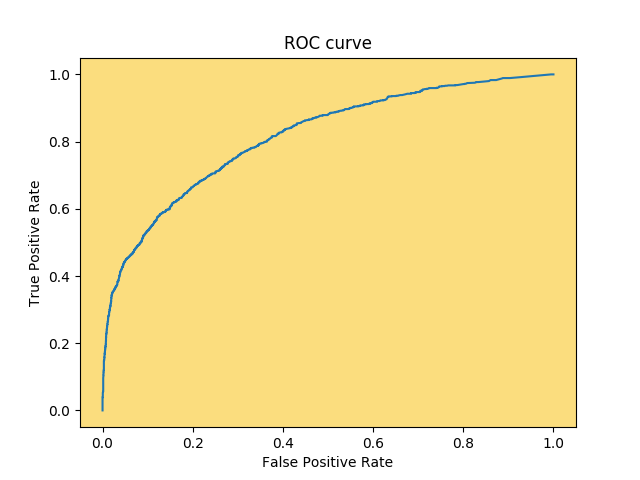

In [16]:
# Gradient Boosted Tree Classifier seems to be the winner model, let us plot its ROC Curve
 

def roc(ax, predictions, labels, title='ROC curve'):
    ''' outputs the roc curve on ax axes'''
    prediction_prob = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    fpr, tpr, _ = roc_curve(labels, prediction_prob)
    ax.plot(fpr, tpr)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
   

plt.clf()

labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
roc(ax, predictions,labels)
#plt.save_fig('lr_roc.png')
%matplot plt